In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import re
import io
import matplotlib.pylab as plt
from fa2 import ForceAtlas2
import json
import ast
from collections import Counter
import pickle
import community
from statistics import mode
import seaborn as sn
import datetime

In [2]:
g = nx.read_gpickle("popular_directors_network.gpickle")

In [3]:
g.number_of_nodes()

1273

In [4]:
g.number_of_edges()

217725

In [5]:
degrees = g.degree()
list_degrees_with_names = sorted(degrees, key=lambda x: x[1], reverse=True)

In [6]:
print('Director who has actors in common with most directors',list_degrees_with_names[0][0])
print('Has actors in common with ' + str(list_degrees_with_names[0][1]) + ' different directors')

Director who has actors in common with most directors Woody Allen
Has actors in common with 1061 different directors


In [7]:
x= list_degrees_with_names[len(list_degrees_with_names)-2][0]
g.node[x]['movies']

[211247, 396535, 389868, 91088]

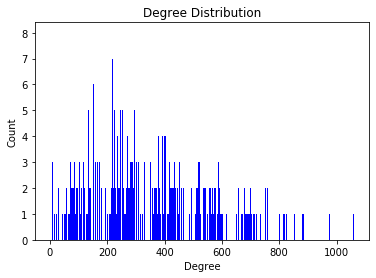

In [8]:
degree_sequence = sorted([d for n, d in g.degree()], reverse=True)
degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.8, color='b')

plt.title("Degree Distribution")
plt.ylabel("Count")
plt.xlabel("Degree")

plt.show()

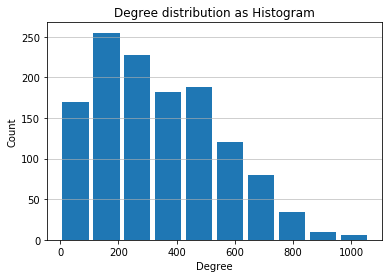

In [9]:
plt.hist(list(dict(nx.degree(g)).values()), rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.title("Degree distribution as Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

In [10]:
degrees_list =[x[1] for x in g.degree()]
print('average: ', np.average(degrees_list))
print('median: ', np.median(degrees_list))
print('mode: ', mode(degrees_list))
print('min: ', np.min(degrees_list))
print('max: ', np.max(degrees_list))

average:  342.0659858601728
median:  308.0
mode:  156
min:  0
max:  1061


In [11]:
print('Top 5 directors regarding degree')
for name,_ in (list_degrees_with_names)[0:5]:
    print(name)

Top 5 directors regarding degree
Woody Allen
Steven Spielberg
Ridley Scott
Martin Scorsese
Oliver Stone


In [12]:
gc = max(nx.connected_component_subgraphs(g), key=len)
len(list(nx.connected_component_subgraphs(g)))

2

In [13]:
betweeness_centrality = nx.betweenness_centrality(gc)

In [14]:
list_betweeness_centrality = sorted(betweeness_centrality.items(), key=lambda x: x[1], reverse=True)
print('Top 5 directors regarding betweeness centrality')
for name,d in (list_betweeness_centrality)[0:5]:
    print(name)

Top 5 directors regarding betweeness centrality
Ridley Scott
Woody Allen
Steven Spielberg
Martin Scorsese
Ron Howard


In [15]:
eigenvector_centrality = nx.eigenvector_centrality(gc)
list_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)
print('Top 5 directors regarding eigenvector centrality')
for name,d in (list_eigenvector_centrality)[0:5]:
    print(name)

Top 5 directors regarding eigenvector centrality
Steven Spielberg
Woody Allen
Ridley Scott
Martin Scorsese
Oliver Stone


## Community detection

In [16]:
gc.number_of_nodes()

1272

In [17]:
partition = community.best_partition(gc)
print('Modularity:', community.modularity(partition, gc))

Modularity: 0.2283736296392426


In [18]:
communities = {}
for key, item in partition.items():
    gc.node[key]["community"] = item
    if item not in communities:
        communities[item] = []
    communities[item].append(key)

In [19]:
for c in communities.items():
    print(str(c[0])+ ': ' + str(len(c[1])))

0: 473
1: 220
2: 339
3: 89
4: 104
5: 47


### Languages

In [21]:
# create dictionary for languages
# if directors have directed movies with languages other than english find the language that appeared the most times
# otherwise set language to english
# reason for not just setting language to majority: we lose some information about directors who have directed some 
# foreigh movies, but still mosty english, as their language will be set to english. 
lan_dict = {}
for d,l in nx.get_node_attributes(gc,'languages').items():
    foreign_l= [y for y in l if y != 'en']
    if len(foreign_l) == 0:
        main_l = 'en'
    else:
        main_l = max(set(foreign_l), key=foreign_l.count)
    if not main_l in lan_dict:
        lan_dict[main_l] = []
    lan_dict[main_l].append(d)

In [22]:
confusion_matrix = np.zeros((len(lan_dict), len(communities)))

for i, l in enumerate(lan_dict.items(), start=0):
    for j, c in enumerate(communities.items(),start=0):
        confusion_matrix[i][j] =len(list(set(c[1]).intersection(l[1])))

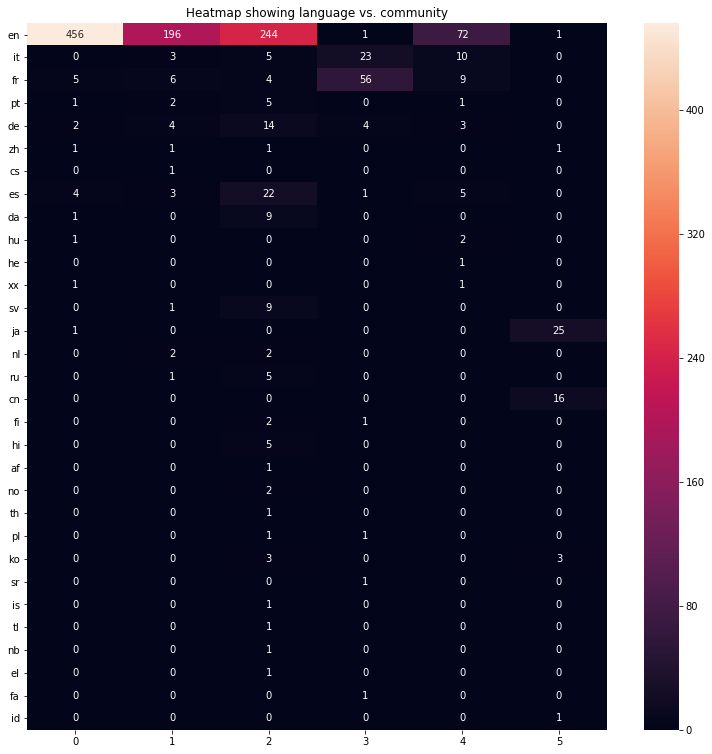

In [24]:

plt.figure(figsize = (13,13))
yticklabels = [l for l in lan_dict]
chart = sn.heatmap(confusion_matrix, annot=True, fmt='g')
chart.set_yticklabels(yticklabels, rotation=0)
plt.title('Heatmap showing language vs. community')
plt.show()

Community 3 and 5 seem to be based on language. Community 3 mostly has mostly directors of french movies and some italian movies, community 5 mostly directors of japanese and cantonese movies. The other communities have mostly directors of english movies.

### Genres

In [25]:
# create dictionary of genres and directors who have directed movies of that genre
# As most movies have multiple genres the same director appears for multiple genres
genres_dict = {}
for d,genres in nx.get_node_attributes(gc,'genres').items():
    for genre in genres:
        if not genre in genres_dict:
            genres_dict[genre] = set()
        genres_dict[genre].add(d)

In [26]:
confusion_matrix = np.zeros((len(genres_dict), len(communities)))

for i, g in enumerate(genres_dict.items(), start=0):
    for j, c in enumerate(communities.items(),start=0):
        confusion_matrix[i][j] =len(list(set(c[1]).intersection(g[1])))

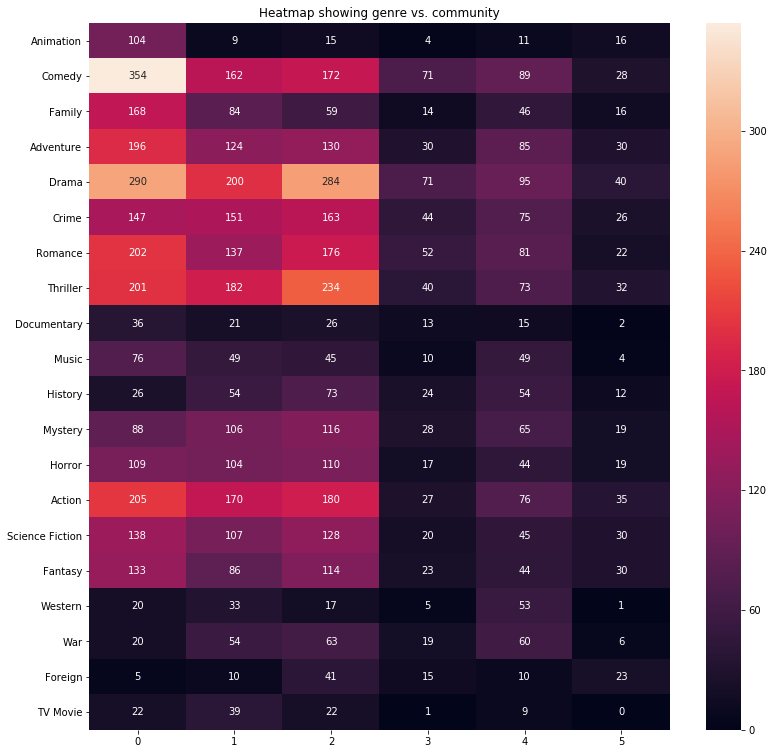

In [27]:
plt.figure(figsize = (13,13))
yticklabels = [l for l in genres_dict]
chart = sn.heatmap(confusion_matrix, annot=True, fmt='g')
chart.set_yticklabels(yticklabels, rotation=0)
plt.title('Heatmap showing genre vs. community')
plt.show()

There can't really be said anything about the communities vs the genres. One reason for this might be that actors do not only act in movies of one genre and directors do not only direct movies of one genre. The fact that each movie is labelled by multiple genres also makes it harder to distinguish between different kinds of movies.  

### Active period

In [33]:
# create dictionary of decade and directors who have directed movies in that decade
period_dict = {1910:[], 1920:[], 1930:[], 1940:[], 1950:[], 1960:[], 1970:[], 1980:[], 1990:[], 2000:[], 2010:[]}
for d in gc.nodes():
    first_movie = datetime.datetime.strptime(gc.node[d]['first_movie'], '%Y-%m-%d')
    last_movie = datetime.datetime.strptime(gc.node[d]['last_movie'], '%Y-%m-%d')
    for p in period_dict.items():
        period_start = datetime.datetime(p[0], 1, 1, 00, 00)
        period_end = datetime.datetime(p[0]+9, 12, 31, 00, 00)
        if last_movie >= period_start and first_movie <= period_end:
            period_dict[p[0]].append(d)

In [34]:
confusion_matrix = np.zeros((len(period_dict), len(communities)))

for i, g in enumerate(period_dict.items(), start=0):
    for j, c in enumerate(communities.items(),start=0):
        confusion_matrix[i][j] =len(list(set(c[1]).intersection(g[1])))

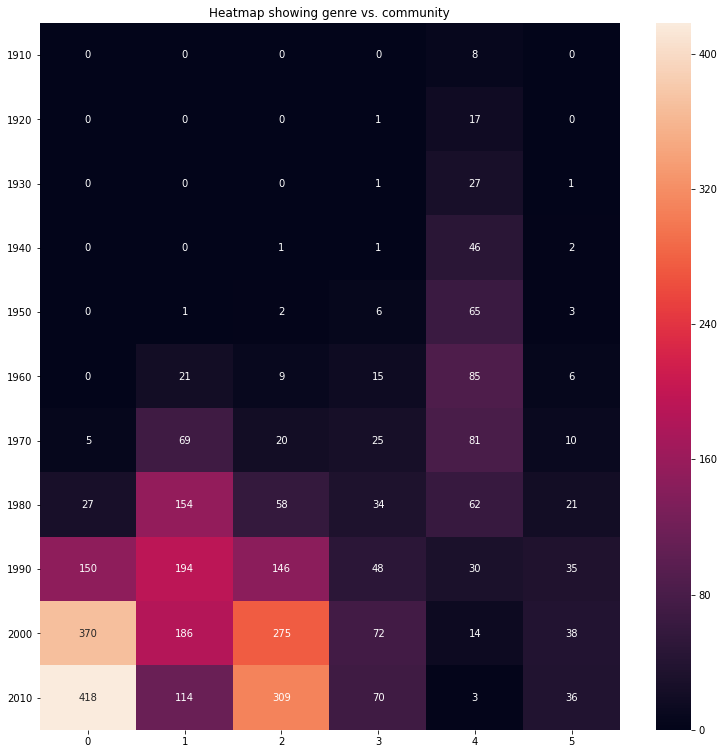

In [35]:
plt.figure(figsize = (13,13))
yticklabels = [l for l in period_dict]
chart = sn.heatmap(confusion_matrix, annot=True, fmt='g')
chart.set_yticklabels(yticklabels, rotation=0)
plt.title('Heatmap showing genre vs. community')
plt.show()

From this figure we can see that community 4 consists mainly of older movies. It makes sense that the directors of older movies are grouped together as not many of the same actors are acting in older as well as newer movies. We can also spot that directors of movies released after year 2000 are in community 0 and 2, while directors of movies from 1980-2000 are more dominant in community 1. Community 3 and 5 mostly consist of directors of movies released after 1980. 

### Rating

In [ ]:
# create dictionary of decade and directors who have directed movies in that decade
period_dict = {1910:[], 1920:[], 1930:[], 1940:[], 1950:[], 1960:[], 1970:[], 1980:[], 1990:[], 2000:[], 2010:[]}
rating_dict = 
for d in gc.nodes():
    first_movie = datetime.datetime.strptime(gc.node[d]['first_movie'], '%Y-%m-%d')
    last_movie = datetime.datetime.strptime(gc.node[d]['last_movie'], '%Y-%m-%d')
    for p in period_dict.items():
        period_start = datetime.datetime(p[0], 1, 1, 00, 00)
        period_end = datetime.datetime(p[0]+9, 12, 31, 00, 00)
        if last_movie >= period_start and first_movie <= period_end:
            period_dict[p[0]].append(d)

In [39]:
ratings = [rating for director, rating in nx.get_node_attributes(gc,'rating').items()]

In [42]:
np.min(ratings)

3.45